In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB #문서 분류엔 나이브베이즈
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from konlpy.tag import Twitter
import nltk
import pyprind

import pandas as pd
import pickle

In [1]:
df = pd.read_csv('edited_user.csv')

In [2]:
df.tail()

,title,id,score,review
30892,Operation Warcade,hobieone,10,Very fun game that captures the old retro arca...
30893,Time Carnage,DeadHeadDraven,8,Fun little shooter - nothing mind blowing but ...
30894,Rogue Aces,dazBOMEGATRON,9,"What you have here is a very well rounded, inc..."
30895,Dusty Raging Fist,TheElGuapo,10,Had fun with it after playing through on easy ...
30896,Dusty Raging Fist,deuxdoom,1,Just don't buy. Worst ever. Seems like a Flash...


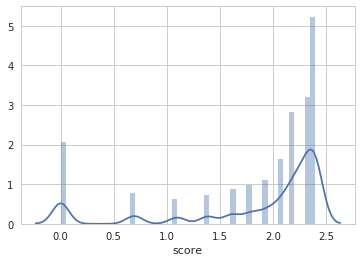

In [4]:
%matplotlib inline
sns.distplot(np.log1p(df.score))

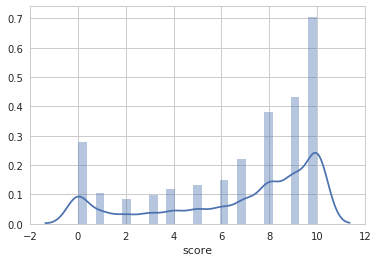

In [5]:
%matplotlib inline
sns.distplot(df.score)

몇 점부터 부정적인 걸까?

In [6]:
df.score = df.score.apply(lambda x: 0 if x< 6 else 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df.review, df.score, test_size=0.1, random_state=1)

len(X_train), len(X_test), len(y_train), len(y_test)

(27807, 3090, 27807, 3090)

In [21]:
import nltk

In [22]:
clf = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,2), stop_words='english'
                            ,tokenizer =nltk.word_tokenize)), 
    ('clf', MultinomialNB(alpha=0.01))])

model = clf.fit(X_train, y_train)

model

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
  ...ue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))])

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import *

y_pred = model.predict(X_test)

print("acc:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

acc: 0.8533980582524272
[[ 551  343]
 [ 110 2086]]
             precision    recall  f1-score   support

          0       0.83      0.62      0.71       894
          1       0.86      0.95      0.90      2196

avg / total       0.85      0.85      0.85      3090



### test

In [11]:
X_test = X_test.reset_index(drop=True)
X_test[0][:100], X_test[1][:100], X_test[2][:100]

result = model.predict([X_test[0], X_test[1], X_test[2]])
result

array([1, 1, 1])

In [13]:
classification_dict = {
    0: "bad", 1: "good",
}

for idx, category in enumerate(result):
    print(classification_dict[category], X_test[idx][:50])

good The game was very good The story of the game is ro
good A great rhythm game with lots of content in the ba
good Although I dislike the episodic approach, this gam


---

In [59]:
test = df[['review', 'score']]

In [60]:
test.to_csv('test.csv', index=False)

---

In [48]:
test = pd.read_csv('test.csv')

In [59]:
test.tail()

,review,score
30892,Very fun game that captures the old retro arca...,1
30893,Fun little shooter - nothing mind blowing but ...,1
30894,"What you have here is a very well rounded, inc...",1
30895,Had fun with it after playing through on easy ...,1
30896,Just don't buy. Worst ever. Seems like a Flash...,0


In [50]:
def stream_docs(path):
    with open(path, 'r') as csv:
        next(csv) #skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

In [51]:
next(stream_docs(path='./test.csv'))

('"Kazuma Kiryu\'s last game (no spoilers)  I managed to get Yakuza 6 a little earlier and my opinion on it is highly positive. The game is really immersive with a cast made out of very wholesome, comedic and plain evil characters. The story takes you to both Onomichi and Kamurocho in yet another tale of our beloved Dragon.    The story itself is really good. Yakuza 6 has a really"',
 1)

In [52]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
         for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [70]:
vect = HashingVectorizer(
#                         ngram_range=(1,2), 
                        stop_words='english',
                        decode_error='ignore',
                        n_features=2**21,
                        preprocessor=None,
#                         non_negative=True,
                        tokenizer =nltk.word_tokenize,
                        )

In [71]:
clf = SGDClassifier(loss='log', random_state=1, max_iter=1)

In [72]:
# clf = MultinomialNB(alpha=0.01)

In [73]:
pbar = pyprind.ProgBar(31)
classes = np.array([0, 1])
for _ in range(31):
    X_train, y_train = get_minibatch(stream_docs(path='./test.csv'), size = 1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:34


In [74]:
X_test, y_test = get_minibatch(stream_docs(path='./test.csv'), size=5000)

In [75]:
X_test = vect.transform(X_test)
print(clf.score(X_test, y_test))

0.8262


In [68]:
# MultinomialNB 결과
# X_test = vect.transform(X_test)
# print(clf.score(X_test, y_test))
# 0.7984

/home/mk/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


0.7984


In [76]:
clf.partial_fit(X_test, y_test)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=1, shuffle=True,
       tol=None, verbose=0, warm_start=False)

update

---

In [77]:
import pickle 
import os

dest = os.path.join('gameclassifier', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)
pickle.dump(clf, open(os.path.join(dest, 'classifier.pkl'), 'wb'), protocol=4)

sql

In [78]:
import sqlite3
import os

conn = sqlite3.connect('review.sqlite')
c = conn.cursor()
c.execute('CREATE TABLE review_db'\
                 ' (review TEXT, sentiment INTEGER)')


In [79]:
example1 = ' I love this game'
c.execute("INSERT INTO review_db"\
             "(review, sentiment) VALUES"\
             " (?, ?)", (example1, 1))

In [80]:
example2 = ' I hate this game'
c.execute("INSERT INTO review_db"\
             "(review, sentiment) VALUES"\
             " (?, ?)", (example2, 0))

In [81]:
conn.commit()
conn.close()

In [83]:
conn = sqlite3.connect('review.sqlite')
c = conn.cursor()
c.execute("SELECT * FROM review_db")
result = c.fetchall()
conn.close()
print(result)

[(' I love this game', 1), (' I hate this game', 0)]
